# Final Project Combined Preliminary EDA

In [1]:
# import libraries
import numpy as np
from numpy import errstate,isneginf
import pandas as pd
from time import time
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import re as re
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sns.set(style = 'white')

%matplotlib inline

## Install Reverse Geocoder
This helps us get county and city data against longtitude and latitude zillow data. Source: https://github.com/thampiman/reverse-geocoder

In [2]:
# only need to install reverse_geocoder if never installed before
# !pip install reverse_geocoder
import reverse_geocoder as rg

## Read in Data

In [3]:
# load the data 
train_2016 = pd.read_csv("train_2016_v2.csv")
properties_2016 = pd.read_csv("properties_2016.csv")

# Ray reading in data from a different file location - comment this out if you need to change it please
# train_2016 = pd.read_csv("~/GitHub/berkeley/W207/zillow_final_project/zillow-prize-1/train_2016_v2.csv")
# properties_2016 = pd.read_csv("~/GitHub/berkeley/W207/zillow_final_project/zillow-prize-1/properties_2016.csv")

C:\Users\ehuang\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exploratory Data Analysis

In [4]:
# look at properties 2016 dataframe
properties_2016.describe(include='all').transpose().sort_values(by='count')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
storytypeid,1624,NaN,NaN,NaN,7,0,7,7,7,7,7
basementsqft,1628,NaN,NaN,NaN,646.883,538.793,20,272,534,847.25,8516
yardbuildingsqft26,2647,NaN,NaN,NaN,278.297,369.732,10,96,168,320,6141
fireplaceflag,5163,1,True,5163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
architecturalstyletypeid,6061,NaN,NaN,NaN,7.20261,2.43629,2,7,7,7,27
typeconstructiontypeid,6747,NaN,NaN,NaN,5.99956,0.38405,4,6,6,6,13
finishedsquarefeet13,7672,NaN,NaN,NaN,1178.9,357.073,120,960,1296,1440,2688
buildingclasstypeid,12629,NaN,NaN,NaN,3.72595,0.5017,1,3,4,4,5
decktypeid,17096,NaN,NaN,NaN,66,0,66,66,66,66,66
finishedsquarefeet6,22001,NaN,NaN,NaN,2414.34,7695.3,117,1079,1992,3366,952576


In [5]:
# look at train 2016 dataframe
train_2016.describe(include='all').transpose().sort_values(by='count')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
parcelid,90275,NaN,NaN,NaN,1.29847e+07,2.50451e+06,1.07117e+07,1.15595e+07,1.25473e+07,1.42276e+07,1.62961e+08
logerror,90275,NaN,NaN,NaN,0.0114572,0.161079,-4.605,-0.0253,0.006,0.0392,4.737
transactiondate,90275,352,2016-07-29,910,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Merge train + properties data

In [7]:
# create the train and dev subsets from 2016 data
combined_df = properties_2016.merge(train_2016, on='parcelid', how='inner',left_index=True,right_index=True, copy='False')
combined_df.set_index(keys='parcelid',inplace=True)

In [8]:
# convert Lat/Long to actual Lat/Long
# note - run this cell one-time or latitude/longtitude will continue to divide by 1e6
combined_df['latitude'] = combined_df['latitude']/1e6
combined_df['longitude'] = combined_df['longitude']/1e6

# combine latitude and longtitude into one column
combined_df['latlng'] = combined_df['latitude'].map(str) + ',' + combined_df['longitude'].map(str)

## Map Latitude + Longitude to City & County

In [11]:
# lookup lat/long locations
coordinates = combined_df["latlng"].apply(lambda x: tuple(x.split(',')))
results = rg.search(coordinates.tolist())

city = [result.get("name") for result in results]
county = [result.get("admin2") for result in results]

combined_df['city'] = city
combined_df['county'] = county

# create a combined variable for better categorization
combined_df['county_city'] = list(zip(county, city))
combined_df['county_city'] = combined_df['county_city'].astype('category')

In [13]:
# verify that city, county, and county_city are pulled in correctly
combined_df.head(2)

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,latlng,city,county,county_city
parcelid,,,,,,,,,,,,,,,,,,,,,
10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0276,2016-01-01,"34.144442,-118.654084",Hidden Hills,Los Angeles County,"(Los Angeles County, Hidden Hills)"
10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.1684,2016-01-01,"34.14043,-118.625364",Calabasas,Los Angeles County,"(Los Angeles County, Calabasas)"


## <font color=red> Column analysis </font>
<font color=purple>**Ray to figure out what preliminary columns to keep versus drop** <font>


In [14]:
# create a deep copy of the merged dataframe (combined_df) above
ray_df = combined_df.copy(deep = True)

# AB: Double check what those categories are
print(ray_df['county_city'].cat.categories)

Index([('Kern County', 'Edwards Air Force Base'),
                        ('Kern County', 'Lebec'),
                     ('Kern County', 'Rosamond'),
                 ('Los Angeles County', 'Acton'),
                ('Los Angeles County', 'Agoura'),
          ('Los Angeles County', 'Agoura Hills'),
            ('Los Angeles County', 'Agua Dulce'),
              ('Los Angeles County', 'Alhambra'),
          ('Los Angeles County', 'Alondra Park'),
              ('Los Angeles County', 'Altadena'),
       ...
                    ('Ventura County', 'Oxnard'),
             ('Ventura County', 'Oxnard Shores'),
                      ('Ventura County', 'Piru'),
              ('Ventura County', 'Port Hueneme'),
               ('Ventura County', 'Santa Paula'),
              ('Ventura County', 'Santa Susana'),
                   ('Ventura County', 'Saticoy'),
               ('Ventura County', 'Simi Valley'),
             ('Ventura County', 'Thousand Oaks'),
                   ('Ventura County', '

In [15]:
print(ray_df.columns)
print(len(ray_df.columns))

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'y

In [16]:
ray_df[ray_df.columns[0:20]].dtypes

airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
dtype: object

In [17]:
ray_df[ray_df.columns[20:40]].dtypes

garagetotalsqft              float64
hashottuborspa                object
heatingorsystemtypeid        float64
latitude                     float64
longitude                    float64
lotsizesquarefeet            float64
poolcnt                      float64
poolsizesum                  float64
pooltypeid10                 float64
pooltypeid2                  float64
pooltypeid7                  float64
propertycountylandusecode     object
propertylandusetypeid        float64
propertyzoningdesc            object
rawcensustractandblock       float64
regionidcity                 float64
regionidcounty               float64
regionidneighborhood         float64
regionidzip                  float64
roomcnt                      float64
dtype: object

In [18]:
ray_df[ray_df.columns[40:]].dtypes

storytypeid                    float64
threequarterbathnbr            float64
typeconstructiontypeid         float64
unitcnt                        float64
yardbuildingsqft17             float64
yardbuildingsqft26             float64
yearbuilt                      float64
numberofstories                float64
fireplaceflag                   object
structuretaxvaluedollarcnt     float64
taxvaluedollarcnt              float64
assessmentyear                 float64
landtaxvaluedollarcnt          float64
taxamount                      float64
taxdelinquencyflag              object
taxdelinquencyyear             float64
censustractandblock            float64
logerror                       float64
transactiondate                 object
latlng                          object
city                            object
county                          object
county_city                   category
dtype: object

In [20]:
def cat_or_float(df):
    categorical_col = []
    continuous_col = []
    for i in df.columns:
        if type(df[i].iloc[1]) == str:
            categorical_col.append(i)
        if type(df[i].iloc[1]) == np.float64:
            continuous_col.append(i)
    return continuous_col, categorical_col

In [21]:
cont_col, cat_col = cat_or_float(ray_df)

In [22]:
print(cont_col)
print(cat_col)

['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear', 'census

In [23]:
# add logerror into the cat_col
for i in cat_col:
    print('categorical column {0} contains {1} unique values for dummy columns'.format(i, len(ray_df[i].unique())))
cat_col.append('logerror')
print(ray_df['city'].unique())

categorical column propertycountylandusecode contains 109 unique values for dummy columns
categorical column propertyzoningdesc contains 2144 unique values for dummy columns
categorical column transactiondate contains 352 unique values for dummy columns
categorical column latlng contains 84562 unique values for dummy columns
categorical column city contains 227 unique values for dummy columns
categorical column county contains 6 unique values for dummy columns
['Hidden Hills' 'Calabasas' 'Ladera Heights' 'Sherman Oaks'
 'North Hollywood' 'Universal City' 'Burbank' 'San Fernando' 'Northridge'
 'Valencia' 'Santa Clarita' 'Desert View Highlands' 'Littlerock'
 'Lancaster' 'View Park-Windsor Hills' 'Westmont' 'Inglewood' 'Lennox'
 'Lawndale' 'Culver City' 'Marina del Rey' 'Santa Monica' 'Century City'
 'Westwood, Los Angeles' 'Malibu Beach' 'Los Angeles' 'West Hollywood'
 'Florence-Graham' 'Echo Park' 'South Pasadena' 'Belvedere'
 'Boyle Heights' 'East Los Angeles' 'Montebello' 'San Gabriel

In [24]:
cat_df = ray_df[cat_col]
con_df = ray_df[cont_col]

In [25]:
# AB - note to others - this takes forever to run. Skip if you don't need the categories split into dummy variables
df_dummies_cat = pd.get_dummies(cat_df)

In [26]:
print(df_dummies_cat.columns)

Index(['logerror', 'propertycountylandusecode_0',
       'propertycountylandusecode_0100', 'propertycountylandusecode_0101',
       'propertycountylandusecode_0102', 'propertycountylandusecode_0103',
       'propertycountylandusecode_0104', 'propertycountylandusecode_0108',
       'propertycountylandusecode_0109', 'propertycountylandusecode_010C',
       ...
       'city_Willowbrook', 'city_Woodland Hills', 'city_Wrightwood',
       'city_Yorba Linda', 'county_Kern County', 'county_Los Angeles County',
       'county_Orange County', 'county_San Bernardino County',
       'county_Santa Barbara County', 'county_Ventura County'],
      dtype='object', length=87399)


## <font color=green> [Ray] Going to plot corr of continuous variables (53 variables)</font>

In [28]:
print(con_df.columns)

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'structuretaxvaluedollarcnt', 'taxvalue

In [29]:
def col_append(col_ind):
    col = cont_col[col_ind:col_ind+10]
    col.append('logerror')
    return col

In [30]:
df1, df2, df3, df4, df5 = con_df[col_append(0)], con_df[col_append(10)], con_df[col_append(20)], con_df[col_append(30)], con_df[col_append(40)]
df6 = con_df[con_df.columns[50:]]

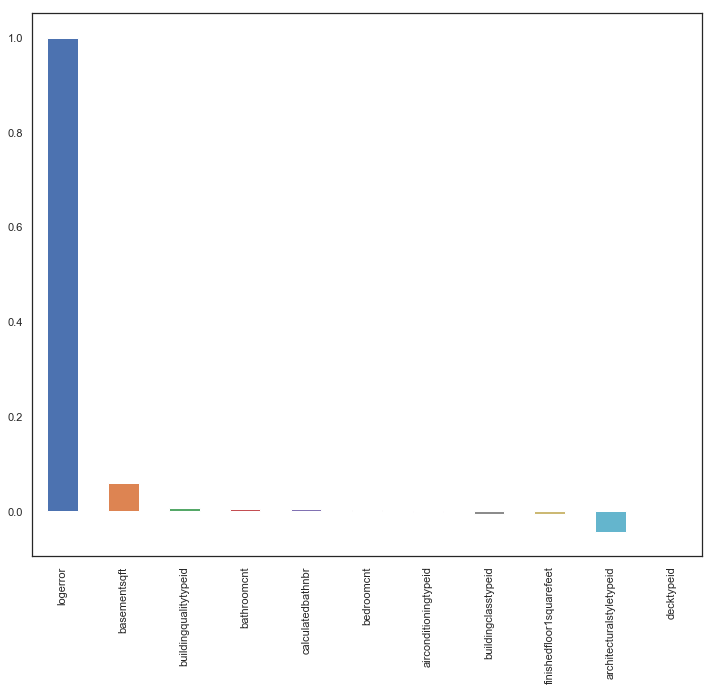

In [31]:
# df1 - get Correlation of "Churn" with other variables:
plt.figure(figsize=(12,10))
df1.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')
plt.show()

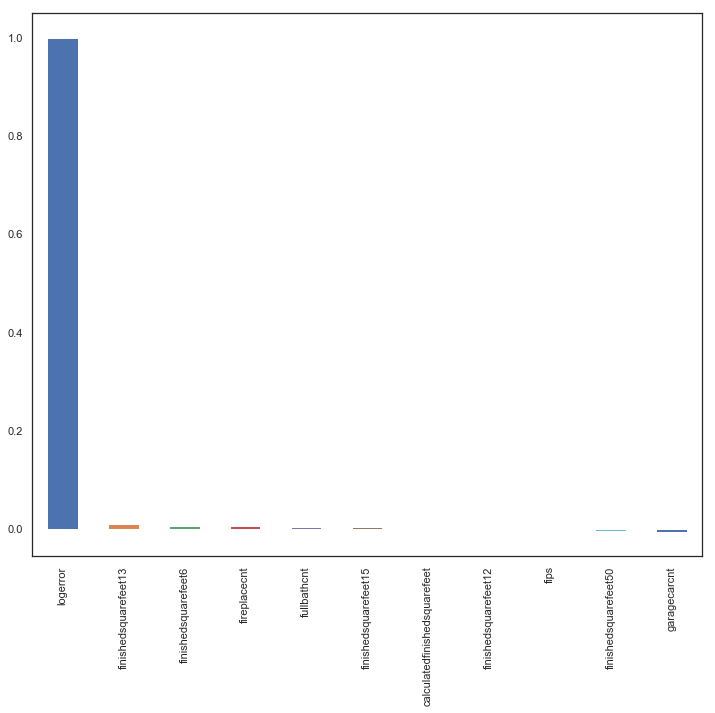

In [32]:
# df2 - get Correlation of "Churn" with other variables:
plt.figure(figsize=(12,10))
df2.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')
plt.show()

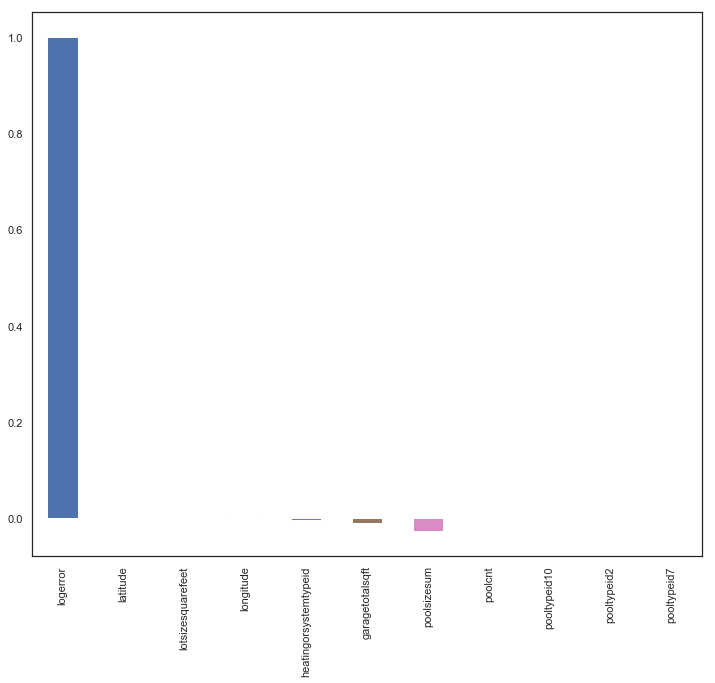

In [33]:
# df3 - get Correlation of "Churn" with other variables:
plt.figure(figsize=(12,10))
df3.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')
plt.show()

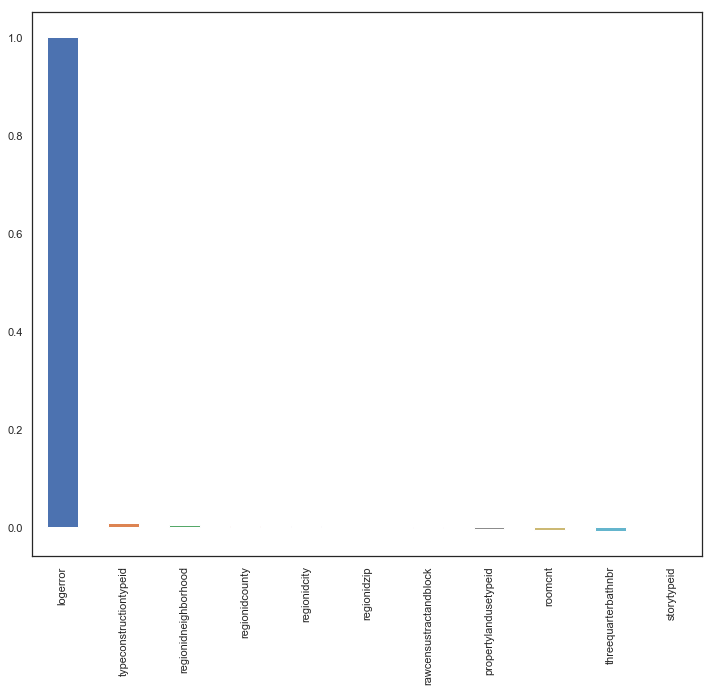

In [34]:
# df4 - get Correlation of "Churn" with other variables:
plt.figure(figsize=(12,10))
df4.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')
plt.show()

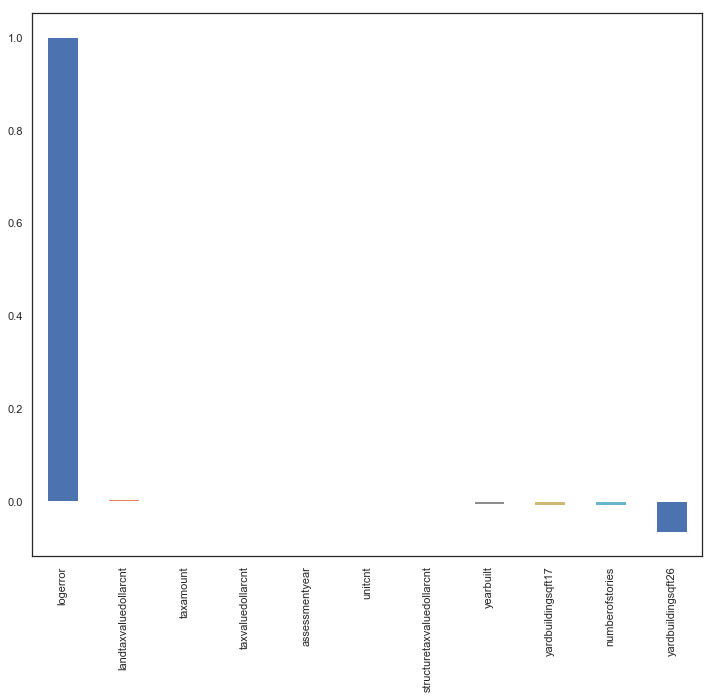

In [35]:
# df5 - get Correlation of "Churn" with other variables:
plt.figure(figsize=(12,10))
df5.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')
plt.show()

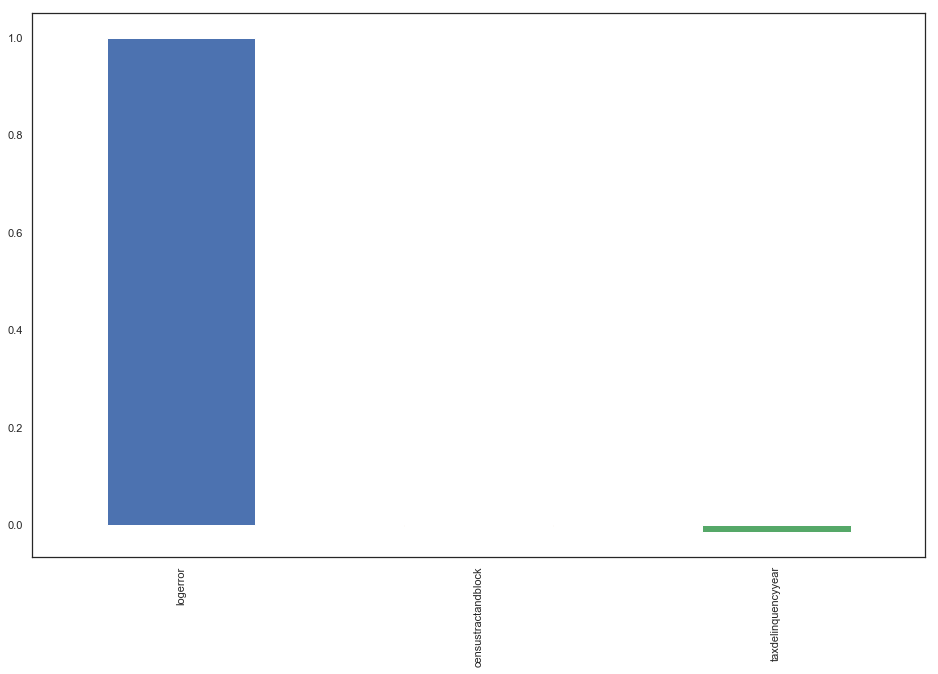

In [36]:
# df6 - get Correlation of "Churn" with other variables:
plt.figure(figsize=(16,10))
df6.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')
plt.show()

## <font color=red> Drop columns <font>
<font color=purple>**Ray to edit the code below after data exploration above as we will no longer drop all the following columns** <font>

In [5]:
# drop sparsely populated columns
properties_2016.drop(labels=['storytypeid','basementsqft','yardbuildingsqft26','architecturalstyletypeid',
                'architecturalstyletypeid','finishedsquarefeet13','buildingclasstypeid','finishedsquarefeet6',
               'finishedsquarefeet15','finishedsquarefeet50','finishedfloor1squarefeet'], axis=1,inplace=True)

# drop categorical columns for now
# TODO create dummy variables
properties_2016.drop(labels=['buildingqualitytypeid', 'decktypeid', 'fips', 'heatingorsystemtypeid', 
                'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 
                'regionidneighborhood', 'regionidzip', 'typeconstructiontypeid', 'censustractandblock'], 
        axis=1,inplace=True)

# drop columns with no variation or those covered by other categories
properties_2016.drop(labels=['propertycountylandusecode', 'propertyzoningdesc','fireplaceflag','assessmentyear','taxdelinquencyyear'], 
        axis=1,inplace=True)

In [6]:
properties_2016.dtypes.transpose()

parcelid                          int64
airconditioningtypeid           float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
poolsizesum                     float64
pooltypeid10                    float64
pooltypeid2                     float64
pooltypeid7                     float64
roomcnt                         float64
threequarterbathnbr             float64
unitcnt                         float64
yardbuildingsqft17              float64
yearbuilt                       float64


In [6]:
# standardize and convert data to 1 or 0
def convert_yn(x):
    if x in ['True','Y']:
        return 1
    return 0

properties_2016['hashottuborspa'] = properties_2016['hashottuborspa'].map(convert_yn)
properties_2016['taxdelinquencyflag'] = properties_2016['taxdelinquencyflag'].map(convert_yn)

In [7]:
# interpolate missing values for the following columns
interpolate_columns = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', \
                      'landtaxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet', \
                      'garagetotalsqft']

# default interpolation method is linear, let's just stick with that
for column in interpolate_columns:
    properties_2016[column].interpolate(inplace=True)

In [8]:
# transform columns with very large st dev to log
log_transform_columns = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', \
                        'taxamount', 'lotsizesquarefeet', 'garagetotalsqft']

eps = 1e-6
for column in log_transform_columns:
    properties_2016[column] = np.log10(properties_2016[column] + eps)


In [9]:
# normalize continuous variables
normalize_columns = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', \
                     'lotsizesquarefeet', 'poolsizesum', 'yardbuildingsqft17', \
                    'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt',
                    'taxamount']

for column in normalize_columns:
    properties_2016[column] = (properties_2016[column] - properties_2016[column].mean()) / properties_2016[column].std()

In [11]:
properties_2016.shape
properties_2016.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,2985217.0,1.332586e+07,7.909966e+06,1.071172e+07,1.164371e+07,1.254509e+07,1.409712e+07,1.696019e+08
airconditioningtypeid,811519.0,1.931166e+00,3.148587e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
bathroomcnt,2973755.0,2.209143e+00,1.077754e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
bedroomcnt,2973767.0,3.088949e+00,1.275859e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.000000e+01
calculatedbathnbr,2856305.0,2.299263e+00,1.000736e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
calculatedfinishedsquarefeet,2929652.0,2.497649e-17,1.000000e+00,-1.003507e+00,-3.374924e-01,-1.402159e-01,1.697116e-01,5.224525e+02
finishedsquarefeet12,2709184.0,1.475316e-17,1.000000e+00,-1.811421e+00,-5.808086e-01,-2.275867e-01,3.192378e-01,2.971852e+02
fireplacecnt,312637.0,1.168710e+00,4.612729e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00
fullbathcnt,2856305.0,2.244165e+00,9.912054e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
garagecarcnt,883267.0,1.823517e+00,6.100354e-01,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.500000e+01


## Train Data EDA

In [10]:
train_2016.transactiondate = pd.to_datetime(train_2016.transactiondate, infer_datetime_format=True)
train_2016.set_index(keys='parcelid',inplace=True)
print(train_2016.shape)
print(train_2016.dtypes)

(90275, 2)
logerror                  float64
transactiondate    datetime64[ns]
dtype: object


## Split dataset into train, dev, and test and filter to July 2016

In [33]:
# split the dataset into train (60%), dev (20%), and test (20%)
# Set a random seed (623) to keep our dataset consistent between runs
# Only use data from July 2016
df = shuffle(df, random_state=623)

df = df[(df['transactiondate'] >= '2016-07-01') & (df['transactiondate'] <= '2016-07-31')]

train_data, train_labels = df.iloc[:int(len(df)*0.6), np.r_[0:30, 31:len(df.columns)]], df.iloc[:int(len(df)*0.6), 30:31].values
df_train = df.iloc[:int(len(df)*0.6), :]
dev_data, dev_labels = df.iloc[int(len(df)*0.6):int(len(df)*0.8), np.r_[0:30, 31:len(df.columns)]], df.iloc[int(len(df)*0.6):int(len(df)*0.8), 30:31].values
df_dev = df.iloc[int(len(df)*0.6):int(len(df)*0.8), :]
test_data, test_labels = df.iloc[int(len(df)*0.8):, np.r_[0:30, 31:len(df.columns)]], df.iloc[int(len(df)*0.8):, 30:31].values
df_test = df.iloc[int(len(df)/2):, :]
print(train_data.shape)


(5968, 34)


In [34]:
# confirm we got the right columns with out slicing
print(*train_data.columns,sep=" - ")

airconditioningtypeid - bathroomcnt - bedroomcnt - calculatedbathnbr - calculatedfinishedsquarefeet - finishedsquarefeet12 - fireplacecnt - fullbathcnt - garagecarcnt - garagetotalsqft - hashottuborspa - latitude - longitude - lotsizesquarefeet - poolcnt - poolsizesum - pooltypeid10 - pooltypeid2 - pooltypeid7 - roomcnt - threequarterbathnbr - unitcnt - yardbuildingsqft17 - yearbuilt - numberofstories - structuretaxvaluedollarcnt - taxvaluedollarcnt - landtaxvaluedollarcnt - taxamount - taxdelinquencyflag - transactiondate - latlng - city - county


## <font color=red> This is the start of feature exploration, selection, and engineering... </font>

In [ ]:
# This *will* take a while to run.
# plot distribution histograms of features 
def plt_hist(df,row,col,cnt):
    fig, ax = plt.subplots(row,col, figsize=(15,15))
    ax = ax.flatten()
    i = 0
    for c in df.columns:
        ax[i].hist(df[c])
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")
        ax[i].set_title(c)
        i+=1
    if cnt < row*col:
        for i in range(cnt,row*col):
            plt.delaxes(ax[i])
    plt.tight_layout()

plt_hist(df_train,7,5,len(df_train.columns))

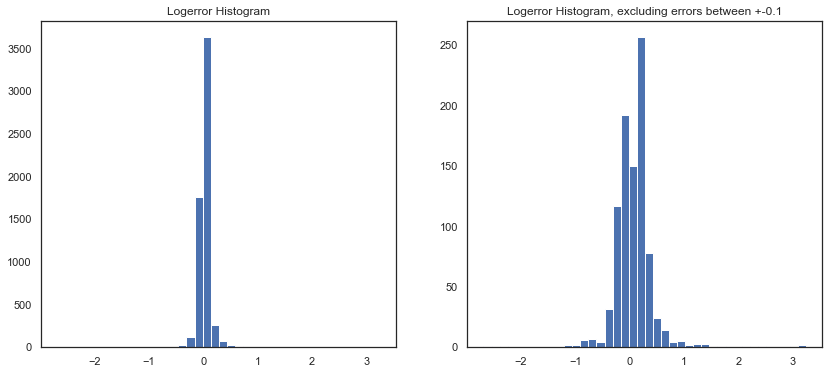

In [35]:
# plot histograms of Logerrors
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax.flatten()
ax[0].hist(df_train.logerror,bins=40)
ax[0].set_title("Logerror Histogram")
ax[1].hist(df_train.logerror[np.abs(df_train.logerror) >= 0.1],bins=40)
ax[1].set_title("Logerror Histogram, excluding errors between +-0.1")
plt.show()

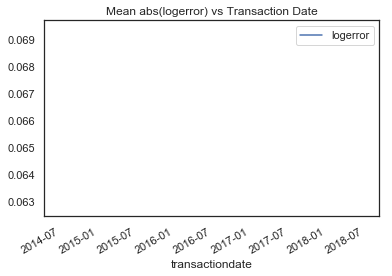

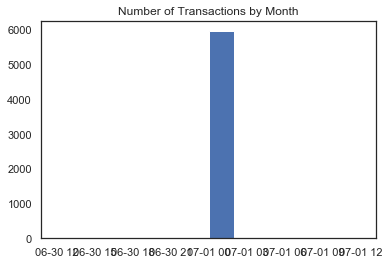

In [36]:
# plot logerrors over time
plt_df = df_train[['transactiondate','logerror']].copy()
plt_df['transactiondate'] = plt_df.transactiondate.astype('datetime64[M]')
plt_df['logerror'] = np.abs(plt_df.logerror)
g = plt_df.groupby(['transactiondate']).mean()
g.plot()
plt.title("Mean abs(logerror) vs Transaction Date")
plt.show()
plt.hist(plt_df.transactiondate,bins=12)
plt.title("Number of Transactions by Month")
plt.show()

In [37]:
# make new dataframe with absolute logerror
new_df = df_train.copy()

new_df['transactiondate'] = new_df.transactiondate.astype('datetime64[M]')
new_df['abs_logerror'] = np.abs(new_df.logerror)
new_df = new_df[new_df.transactiondate == '2016-12-01']
new_df.sort_values(by=['abs_logerror'],inplace=True, ascending=False)

new_df.head(8).transpose()

parcelid
airconditioningtypeid
bathroomcnt
bedroomcnt
calculatedbathnbr
calculatedfinishedsquarefeet
finishedsquarefeet12
fireplacecnt
fullbathcnt
garagecarcnt
garagetotalsqft


## Normalize Continuous Variables

In [ ]:
norm_df = df.copy()
norm_df.describe().transpose()

In [ ]:
normalize_columns = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', '']